<a href="https://colab.research.google.com/github/123972/Deep-Learning-Final-Project/blob/master/Propuesta_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Algunas ligas para documentación.
#
# GAN paper por Goodfellow: https://arxiv.org/abs/1406.2661
# Goodfellow's tutorial: https://arxiv.org/abs/1701.00160
# Tutorial en tf (DCGAN): https://www.tensorflow.org/tutorials/generative/dcgan
# Tips by Goodfellow et al., http://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf
#
# Otros recursos
# https://www.youtube.com/watch?v=RRTuumxm3CE
# https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
# https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889
# https://gist.github.com/s33a11ev1l/7917feed3dd59bb3bc2efcdaa02117a3
#
# WGAN paper:https://arxiv.org/abs/1701.07875
# Tips: https://arxiv.org/abs/1704.00028
# Derivación de la pérdida
# https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html
# https://vincentherrmann.github.io/blog/wasserstein/
# Implementación de la pérdida
# https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/
# https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
#
# Otros recursos
# https://www.youtube.com/watch?v=_z9bdayg8ZI
# https://github.com/davidreiman/mnist-wgan
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [5]:
# Load data
(_, _), (X_train, _) = mnist.load_data()
X_train = X_train / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
print(X_train.shape)
print(X_train.min())
print(X_train.max())

(10000, 28, 28, 1)
0.0
1.0


In [0]:
### OLD ### Sí funcionó, pero no congela al discrimimnador
# Define GAN
class GAN(object):
  def __init__(self, n_rows=28, n_cols=28, n_chan=1, latent_len=256):
    '''Class constructor'''
    # Variables
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_chan = n_chan
    self.img_shape = (self.n_rows, self.n_cols, self.n_chan)
    self.latent_len = latent_len
    self.generator = self.build_generator()
    self.discriminator = self.build_discriminator()
    self.combined = self.build_combined()

  def build_generator(self):
    '''Generator'''
    model = Sequential(name='GENERATOR')
    model.add(Input(shape=(self.latent_len,)))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
    model.add(Reshape(self.img_shape))
    model.summary()
    return model

  def build_discriminator(self):
    '''Discriminator'''
    model = Sequential(name='DISCRIMINATOR')
    model.add(Input(shape=self.img_shape))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

  def build_combined(self):
    '''Combine generator and discriminator'''
    z = Input(shape=(self.latent_len,))
    fake_img = self.generator(z)
    y_hat = self.discriminator(fake_img)
    model = Model(z, y_hat, name='FULLGAN')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

  def train(self, X_train, epochs=1000, batch_size=100, save_epoch=100):
    '''Train function'''
    # Create vector of 1s and 0s for labels
    y_P = np.ones((len(X_train), 1))
    y_N = np.zeros((len(X_train), 1))

    print(f"Training with {len(X_train)} samples.")
    print(f"For {epochs} epochs at batch_size={batch_size}.")

    # Create random test noise for further testing
    test_noise = np.random.normal(0, 1, (25, self.latent_len))

    d_loss = []
    d_accu = []
    g_loss = []
    g_accu = []
    for epoch in range(epochs):
      # Generate random-noise samples and predict fake data
      rand_noise = np.random.normal(0, 1, (len(X_train), self.latent_len))
      F_train = self.generator.predict(rand_noise)

      # Train discriminator
      self.discriminator.trainable = True
      d_hist_real = self.discriminator.fit(X_train, y_P, batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
      d_hist_fake = self.discriminator.fit(F_train, y_N, batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
      d_loss.append(0.5 * np.add(d_hist_real.history['loss'][0], d_hist_fake.history['loss'][0]))
      d_accu.append(0.5 * np.add(d_hist_real.history['accuracy'][0], d_hist_fake.history['accuracy'][0]))
      
      # Train generator
      self.discriminator.trainable = False
      g_hist = self.combined.fit(rand_noise, y_P, batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
      g_loss.append(g_hist.history['loss'][0])
      g_accu.append(g_hist.history['accuracy'][0])
      
      # Print out some info, and save visual evidence
      if epoch % save_epoch == 0:
        print("%3d [D loss: %.4f, acc.: %.2f%%] [G loss: %.4f, acc.: %.2f%%]" % (epoch, d_loss[-1], 100 * d_accu[-1], g_loss[-1], 100 * g_accu[-1]))
        self.sample_images(epoch, test_noise)
    return d_loss, d_accu, g_loss, g_accu

  def sample_images(self, epoch, test_noise):
    '''Function to visualiza some generated images'''
    test_imgs = self.generator.predict(test_noise)
    fig, axs = plt.subplots(5, 5)
    ind = 0
    for i in range(5):
      for j in range(5):
        axs[i, j].imshow(test_imgs[ind, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        ind += 1
    fig.savefig("out_images/%d.png" % epoch)
    plt.close()

In [7]:
# Instantiate GAN object
gan = GAN(latent_len=256)

Model: "GENERATOR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               40

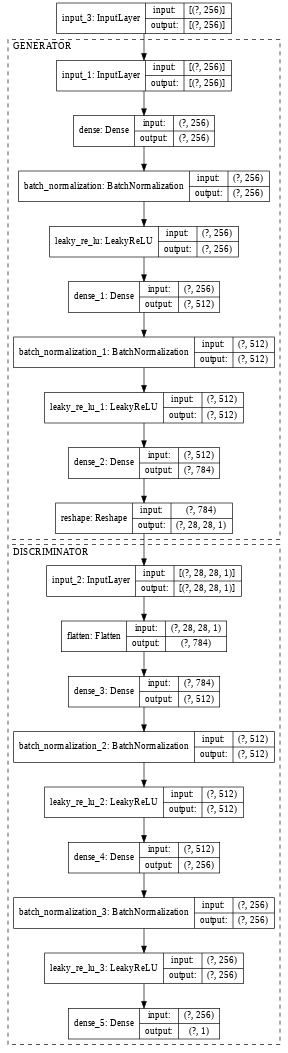

In [0]:
plot_model(gan.combined, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [0]:
# Train GAN
d_loss, d_accu, g_loss, g_accu = gan.train(X_train, epochs=5001, batch_size=10000, save_epoch=100)

Training with 10000 samples.
For 5001 epochs at batch_size=10000.
  0 [D loss: 0.8198, acc.: 49.22%] [G loss: 0.6694, acc.: 59.76%]
100 [D loss: 0.5578, acc.: 53.36%] [G loss: 0.5485, acc.: 71.63%]
200 [D loss: 0.4308, acc.: 62.92%] [G loss: 0.6682, acc.: 57.33%]
300 [D loss: 0.4029, acc.: 70.26%] [G loss: 0.7302, acc.: 48.31%]
400 [D loss: 0.3722, acc.: 76.12%] [G loss: 0.7773, acc.: 40.13%]
500 [D loss: 0.3156, acc.: 89.33%] [G loss: 0.9035, acc.: 30.32%]
600 [D loss: 0.3048, acc.: 89.77%] [G loss: 0.9383, acc.: 27.38%]
700 [D loss: 0.2823, acc.: 93.96%] [G loss: 0.9863, acc.: 21.27%]
800 [D loss: 0.2666, acc.: 94.58%] [G loss: 1.0371, acc.: 17.23%]
900 [D loss: 0.2513, acc.: 95.70%] [G loss: 1.0959, acc.: 13.90%]
1000 [D loss: 0.2552, acc.: 94.41%] [G loss: 1.1163, acc.: 20.39%]
1100 [D loss: 0.2340, acc.: 96.94%] [G loss: 1.1691, acc.: 14.81%]
1200 [D loss: 0.2188, acc.: 98.30%] [G loss: 1.2203, acc.: 13.96%]
1300 [D loss: 0.2014, acc.: 99.16%] [G loss: 1.3233, acc.: 16.56%]
1400 [

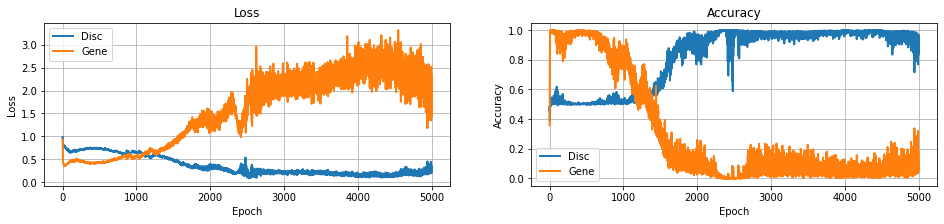

In [0]:
# Plot loss
plt.figure(figsize=(16, 3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(d_loss, label='Disc', linewidth=2)
plt.plot(g_loss, label='Gene', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(d_accu, label='Disc', linewidth=2)
plt.plot(g_accu, label='Gene', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [0]:
# Generate GIF and save it
from PIL import Image
IMGS = []
for ind_img in range(0, 5001, 100):
  IMGS.append(Image.open("out_images/%d.png" % ind_img))

IMGS[0].save('evolution.gif', format='GIF', append_images=IMGS[1:], save_all=True, duration=300, loop=0)

In [0]:
!rm out_images/*

In [0]:
!zip -r /content/images.zip /content/out_images

In [0]:
# Otros intentos

In [0]:
# Define GAN - Itera sobre batches
class GAN(object):
  def __init__(self, n_rows=28, n_cols=28, n_chan=1, latent_len=256):
    '''Class constructor'''
    # Variables
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_chan = n_chan
    self.img_shape = (self.n_rows, self.n_cols, self.n_chan)
    self.latent_len = latent_len
    self.generator = self.build_generator()
    self.discriminator = self.build_discriminator()
    self.combined = self.build_combined()
    print(self.generator.summary())
    print(self.discriminator.summary())
    print(self.combined.summary())

  def build_generator(self):
    '''Generator'''
    model = Sequential(name='GENERATOR')
    model.add(Input(shape=(self.latent_len,)))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
    model.add(Reshape(self.img_shape))
    return model

  def build_discriminator(self):
    '''Discriminator'''
    model = Sequential(name='DISCRIMINATOR')
    model.add(Input(shape=self.img_shape))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

  def build_combined(self):
    '''Combine generator and discriminator'''
    self.discriminator.trainable = False
    z = Input(shape=(self.latent_len,))
    fake_img = self.generator(z)
    y_hat = self.discriminator(fake_img)
    model = Model(z, y_hat, name='FULLGAN')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

  def train(self, X_train, epochs=10000, batch_size=100, save_epoch=100):
    '''Train function'''
    # Num of batches
    n_batches = X_train.shape[0] // batch_size
    print(f"Training with {len(X_train)} samples.")
    print(f"For {epochs} epochs at batch_size={batch_size}, thus {n_batches} batches.")

    ## Create vector of 1s and 0s for labels
    y_R = np.ones((batch_size, 1)) # R for real
    y_F = np.zeros((batch_size, 1))# F for fake

    # Create random test noise for further testing
    test_noise = np.random.normal(0, 1, (25, self.latent_len))

    d_loss = []
    d_accu = []
    g_loss = []
    g_accu = []
    for epoch in range(epochs):
      for batch in range(n_batches):
        # Get a random subset of real images
        X_batch = X_train[np.random.randint(low=0, high=X_train.shape[0], size=batch_size)]

        # Generate random-noise samples and predict fake data
        rand_noise = np.random.normal(0, 1, (batch_size, self.latent_len))
        F_batch = self.generator.predict(rand_noise)

        # Train discriminator
        '''
        print("When training Dis:")
        HIST_WD = self.discriminator.get_weights()[0].copy()
        HIST_WG = self.generator.get_weights()[0].copy()
        '''
        d_hist_real = self.discriminator.train_on_batch(X_batch, y_R)
        d_hist_fake = self.discriminator.train_on_batch(F_batch, y_F)
        d_loss.append(0.5 * np.add(d_hist_real[0], d_hist_fake[0]))
        d_accu.append(0.5 * np.add(d_hist_real[1], d_hist_fake[1]))
        '''
        g = np.round((HIST_WG == self.generator.get_weights()[0]).sum() / np.product(HIST_WG.shape))
        if g == 1:
          print("Gen NO cambia")
        if g == 0:
          print("Gen SI cambia")
        d = np.round((HIST_WD == self.discriminator.get_weights()[0]).sum() / np.product(HIST_WD.shape))
        if d == 1:
          print("Dis NO cambia")
        if d == 0:
          print("Dis SI cambia")
        break
        '''
        
        # Train generator
        '''
        print("When training Gen:")
        HIST_WD = self.discriminator.get_weights()[0].copy()
        HIST_WG = self.generator.get_weights()[0].copy()
        '''
        g_hist = self.combined.train_on_batch(rand_noise, y_R)
        g_loss.append(g_hist[0])
        g_accu.append(g_hist[1])
        '''
        g = np.round((HIST_WG == self.generator.get_weights()[0]).sum() / np.product(HIST_WG.shape))
        if g == 1:
          print("Gen NO cambia")
        if g == 0:
          print("Gen SI cambia")
        d = np.round((HIST_WD == self.discriminator.get_weights()[0]).sum() / np.product(HIST_WD.shape))
        if d == 1:
          print("Dis NO cambia")
        if d == 0:
          print("Dis SI cambia")
        '''

      # Print out some info, and save visual evidence
      if epoch % save_epoch == 0:
        print("%6d [D loss: %6.4f, acc.: %6.2f%%] [G loss: %6.4f, acc.: %6.2f%%]" % (epoch, d_loss[-1], 100 * d_accu[-1], g_loss[-1], 100 * g_accu[-1]))
        self.sample_images(epoch, test_noise)
    return d_loss, d_accu, g_loss, g_accu

  def sample_images(self, epoch, test_noise):
    '''Function to visualiza some generated images'''
    test_imgs = self.generator.predict(test_noise)
    fig, axs = plt.subplots(5, 5)
    ind = 0
    for i in range(5):
      for j in range(5):
        axs[i, j].imshow(test_imgs[ind, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        ind += 1
    fig.savefig("out_images/%d.png" % epoch)
    plt.close()

In [0]:
# Define GAN · Itera sobre batches y combina R con F para entrenadr disc
class GAN(object):
  def __init__(self, n_rows=28, n_cols=28, n_chan=1, latent_len=256):
    '''Class constructor'''
    # Variables
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_chan = n_chan
    self.img_shape = (self.n_rows, self.n_cols, self.n_chan)
    self.latent_len = latent_len
    self.generator = self.build_generator()
    self.discriminator = self.build_discriminator()
    self.combined = self.build_combined()
    print(self.generator.summary())
    print(self.discriminator.summary())
    print(self.combined.summary())

  def build_generator(self):
    '''Generator'''
    model = Sequential(name='GENERATOR')
    model.add(Input(shape=(self.latent_len,)))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
    model.add(Reshape(self.img_shape))
    return model

  def build_discriminator(self):
    '''Discriminator'''
    model = Sequential(name='DISCRIMINATOR')
    model.add(Input(shape=self.img_shape))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

  def build_combined(self):
    '''Combine generator and discriminator'''
    self.discriminator.trainable = False
    z = Input(shape=(self.latent_len,))
    fake_img = self.generator(z)
    y_hat = self.discriminator(fake_img)
    model = Model(z, y_hat, name='FULLGAN')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

  def train(self, X_train, epochs=10000, batch_size=100, save_epoch=100):
    '''Train function'''
    # Num of batches
    n_batches = X_train.shape[0] // batch_size
    print(f"Training with {len(X_train)} samples.")
    print(f"For {epochs} epochs at batch_size={batch_size}, thus {n_batches} batches.")

    ## Create vector of 1s and 0s for labels
    y_R = np.ones((batch_size, 1)) # R for real
    y_F = np.zeros((batch_size, 1))# F for fake

    # Create random test noise for further testing
    test_noise = np.random.normal(0, 1, (25, self.latent_len))

    d_loss = []
    d_accu = []
    g_loss = []
    g_accu = []
    for epoch in range(epochs):
      for batch in range(n_batches):
        # Get a random subset of real images
        X_batch = X_train[np.random.randint(low=0, high=X_train.shape[0], size=batch_size)]

        # Generate random-noise samples and predict fake data
        rand_noise = np.random.uniform(0, 1, (batch_size, self.latent_len))
        F_batch = self.generator.predict(rand_noise)

        # Put real and fake data together into a batch
        x = np.concatenate((X_batch, F_batch))
        x = np.random.permutation(x)
        y = np.concatenate((y_R, y_F))
        y = np.random.permutation(y)

        # Train generator
        '''
        print("When training Gen:")
        HIST_WD = self.discriminator.get_weights()[0].copy()
        HIST_WG = self.generator.get_weights()[0].copy()
        '''
        g_hist = self.combined.train_on_batch(rand_noise, y_R)
        g_loss.append(g_hist[0])
        g_accu.append(g_hist[1])
        '''
        g = np.round((HIST_WG == self.generator.get_weights()[0]).sum() / np.product(HIST_WG.shape))
        if g == 1:
          print("Gen NO cambia")
        if g == 0:
          print("Gen SI cambia")
        d = np.round((HIST_WD == self.discriminator.get_weights()[0]).sum() / np.product(HIST_WD.shape))
        if d == 1:
          print("Dis NO cambia")
        if d == 0:
          print("Dis SI cambia")
        '''

        # Train discriminator
        '''
        print("When training Dis:")
        HIST_WD = self.discriminator.get_weights()[0].copy()
        HIST_WG = self.generator.get_weights()[0].copy()
        '''
        d_hist = self.discriminator.train_on_batch(x, y)
        d_loss.append(d_hist[0])
        d_accu.append(d_hist[1])
        #d_hist_real = self.discriminator.train_on_batch(X_batch, y_R)
        #d_hist_fake = self.discriminator.train_on_batch(F_batch, y_F)
        #d_loss.append(0.5 * np.add(d_hist_real[0], d_hist_fake[0]))
        #d_accu.append(0.5 * np.add(d_hist_real[1], d_hist_fake[1]))
        '''
        g = np.round((HIST_WG == self.generator.get_weights()[0]).sum() / np.product(HIST_WG.shape))
        if g == 1:
          print("Gen NO cambia")
        if g == 0:
          print("Gen SI cambia")
        d = np.round((HIST_WD == self.discriminator.get_weights()[0]).sum() / np.product(HIST_WD.shape))
        if d == 1:
          print("Dis NO cambia")
        if d == 0:
          print("Dis SI cambia")
        break
        '''


      # Print out some info, and save visual evidence
      if epoch % save_epoch == 0:
        print("%6d [D loss: %6.4f, acc.: %6.2f%%] [G loss: %6.4f, acc.: %6.2f%%]" % (epoch, d_loss[-1], 100 * d_accu[-1], g_loss[-1], 100 * g_accu[-1]))
        self.sample_images(epoch, test_noise)
    return d_loss, d_accu, g_loss, g_accu

  def sample_images(self, epoch, test_noise):
    '''Function to visualiza some generated images'''
    test_imgs = self.generator.predict(test_noise)
    fig, axs = plt.subplots(5, 5)
    ind = 0
    for i in range(5):
      for j in range(5):
        axs[i, j].imshow(test_imgs[ind, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        ind += 1
    fig.savefig("out_images/%d.png" % epoch)
    plt.close()